# Content Segmentation

This notebook notebook evaluates the method of Satoshi Tsutsui, and David Crandall (2017)\[https://github.com/apple2373/figure-separator] in a subset figures of our dataset. 

We make available [here](https://drive.google.com/file/d/1mkFs7zOjCAyjHBPqJP1jhl49kKvMmtC4/view?usp=sharing) an adapted version of FigureSeparator method, along with the ground-truth of the content segmentation

# Instructions
1. Download the files from this [here](https://drive.google.com/file/d/1mkFs7zOjCAyjHBPqJP1jhl49kKvMmtC4/view?usp=sharing)
2. Unzip the files
3. With a kernel python3.6, install the requirements from panel_extraction_src/requirements.txt
4. Run the cells bellow

----

# Download and unzip groundtruth and model

In [ ]:
%%bash
# Dowload and unzip groundtruth and model
FILENAME='content_segmentation.zip'
FILEID='1mkFs7zOjCAyjHBPqJP1jhl49kKvMmtC4'
wget --load-cookies /tmp/cookies.txt -nc \
    "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate "https://docs.google.com/uc?export=download&id=$FILEID" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILEID" \
    -O $FILENAME && rm -rf /tmp/cookies.txt
unzip -nq $FILENAME


# Import Cell

In [2]:
import os
from panel_extraction_src.PanelExtraction import PanelExtraction
import numpy as np
import cv2
from glob import glob
from PIL import Image
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
# Remove warnings
import warnings
warnings.filterwarnings('ignore')
# Initialize instance of PanelExtraction
panel_extraction=PanelExtraction("panel_extraction_src/panel_extraction.pb")
# Clear output
from IPython.display import clear_output
clear_output()

In [3]:
def create_panels_mask(img,panels):
    """
    Create a maks image based on the panels location
    """
    if ".gif" in img:
        img = np.array(Image.open(img))
    else:
        img = cv2.imread(img)
    color = (255, 255, 255)
    img = np.zeros_like(img)
    for panel in panels:
        start_point = (panel['x'],panel['y'])
        end_point = (panel['x']+panel['w'], panel['y']+panel['h'])
        img = cv2.rectangle(img, start_point, end_point, color, -1) 
    return img

# Run Method for each selected figure

In [4]:
figs = glob("selected_figures/*")
figs.sort()

In [5]:
# Creates a folder to save all mask images resulting from 
# the panel extraction
os.makedirs("panels_mask", exist_ok=True)

In [6]:
# For each figure apply the FigureSeparator method
# and save the resulting mask
total_figs = len(figs)
for fig_index, fig in enumerate(figs,start=1):
    # extracts the panels
    panels = panel_extraction.extract(fig)
    # create a maks image based on the panels location
    mask = create_panels_mask(fig,panels)
    
    # Fix fig name
    fig = fig.replace("selected_figures",'panels_mask')
    fig  = fig.split(".")[0] +".png"
    
    cv2.imwrite(fig,mask)
        
    
    print(f"Extracting {fig_index} / {total_figs}",end='\r',flush=True)
    
print('\nDone')


Extracting 321 / 321
Done


# Method Evaluation

In [7]:
# Read all the ground-truth files and the gerated masks
gt = sorted(glob("xp1_and_xp2/*"))
panels_mask = sorted(glob("panels_mask/*"))
if len(gt) != len(panels_mask):
    raise "The number of mask does not match with the number of gt"

In [14]:
score = []
total_figs = len(gt)
for index in range(len(gt)):
    # ground-truth
    gt_mask = cv2.imread(gt[index],cv2.IMREAD_GRAYSCALE)
    gt_mask[gt_mask>0] =1
    gt_mask = gt_mask.flatten()
    # predicted mask
    pred_mask = cv2.imread(panels_mask[index],cv2.IMREAD_GRAYSCALE)
    pred_mask[pred_mask>0] =1
    pred_mask = pred_mask.flatten()
    
    score.append(jaccard_score(y_true=pred_mask, y_pred=gt_mask))
    print(f"Calculating Score {index+1} / {total_figs}",end='\r',flush=True)
print('\nDone')

Calculating Score 321 / 321
Done


## Plot Result

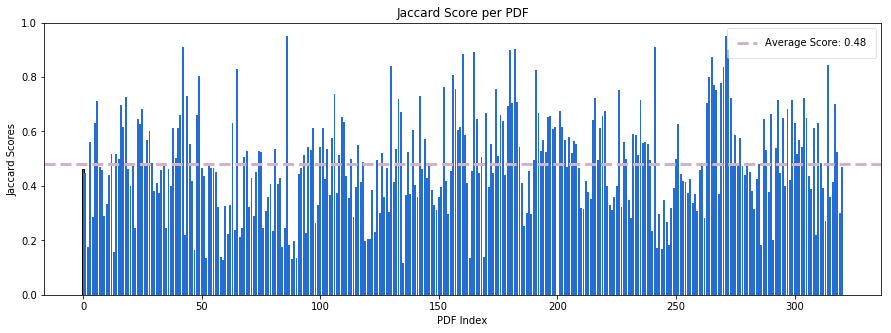

Score: 0.48 +/- 0.18


In [16]:
y = np.array(score)
x = np.arange(len(score))

plt.figure(figsize=(15,5))
plt.axhline(y.mean(), color='#CFB3CD', linestyle='dashed', linewidth=3,label=f'Average Score: {y.mean():.2f}')
plt.bar(x, score, facecolor='#266DD3',edgecolor='black')
plt.title("Jaccard Score per PDF")
plt.xlabel('PDF Index')
plt.ylabel("Jaccard Scores")
plt.legend(fancybox=True, framealpha=0.6, borderpad=1)

plt.show()

print(f"Score: {y.mean():.2f} +/- {y.std():.2f}")

----

# Check Agreement between the experts annotations


In [10]:
# Read all the ground-truth from each expert
xp1 = sorted(glob("xp1/*"))
xp2 = sorted(glob("xp2/*"))
if len(xp1) != len(xp2):
    raise "The number of ground-truth between the experts does not match"

In [11]:
score = []
total_figs = len(xp1)
for index in range(len(xp1)):
    # ground-truth
    mask_xp1 = cv2.imread(xp1[index],cv2.IMREAD_GRAYSCALE)
    mask_xp1[mask_xp1>0] =1
    mask_xp1 = mask_xp1.flatten()
    # predicted mask
    mask_xp2 = cv2.imread(xp2[index],cv2.IMREAD_GRAYSCALE)
    mask_xp2[mask_xp2>0] =1
    mask_xp2 = mask_xp2.flatten()
    
    score.append(jaccard_score(mask_xp1, mask_xp2))
    print(f"Calculating Score {index+1} / {total_figs}",end='\r',flush=True)
print('\nDone')

Calculating Score 321 / 321
Done


# Plot Agreement Between Experts

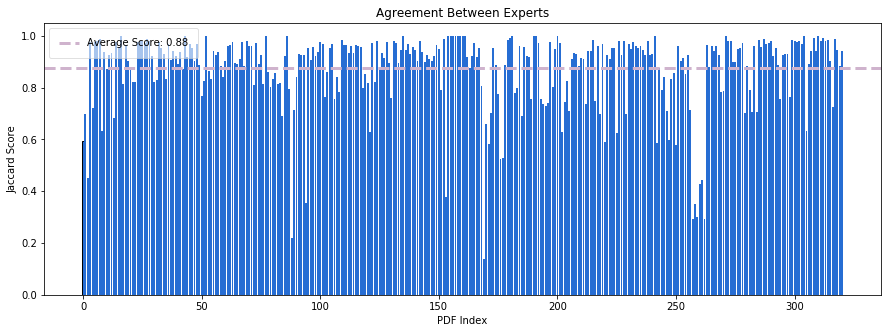

Score: 0.88 +/- 0.15


In [13]:
y = np.array(score)
x = np.arange(len(score))

plt.figure(figsize=(15,5))
plt.axhline(y.mean(), color='#CFB3CD', linestyle='dashed', linewidth=3,label=f'Average Score: {y.mean():.2f}')
plt.bar(x, score, facecolor='#266DD3',edgecolor='black')
plt.title("Agreement Between Experts")
plt.xlabel('PDF Index')
plt.ylabel("Jaccard Score")
plt.legend(fancybox=True, framealpha=0.6, borderpad=1)

plt.show()

print(f"Score: {y.mean():.2f} +/- {y.std():.2f}")